In [1]:
!pip install torchview
!pip install graphviz

In [2]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
from torchvision import models
import torch.utils.data
import torch.nn
import torch.nn.functional as functional
import numpy as np
import time
import os
import graphviz
from torchview import draw_graph
from matplotlib import pyplot as plt

## **1. Загрузка данных**

In [3]:
dir_name = os.getcwd()
def download_datasets(transform):
  train_dataset = torchvision.datasets.CIFAR10(
      root = dir_name, train = True, download = True,
      transform = transform
  )
  test_dataset = torchvision.datasets.CIFAR10(
      root = dir_name, train = False, download = True,
      transform = transform
  )
  return train_dataset, test_dataset

## **2. Архитектура сети**

In [4]:
learning_rate = 0.001
num_epochs = 5
batch_size = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_function = torch.nn.CrossEntropyLoss()

In [5]:
def get_loaders(train_dataset, test_dataset):
  train_data_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True,
  )
  test_data_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size = batch_size, shuffle = False, num_workers=4, pin_memory=True,
  )
  return train_data_loader, test_data_loader

In [6]:
def create_model_first(class_model, weights):
  neural_network = class_model(weights = weights)

  for params in neural_network.parameters():
    params.requires_grad = False

  input_layers = neural_network.fc.in_features

  neural_network.fc = torch.nn.Linear(input_layers, 10)
  return neural_network

def create_model_second(class_model, weights):
  neural_network = class_model(weights = weights)

  for params in neural_network.parameters():
    params.requires_grad = False

  input_layers = neural_network.fc.in_features

  neural_network.fc = torch.nn.Sequential(
        torch.nn.Linear(input_layers, input_layers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(input_layers//2, 10),
        )
  return neural_network

In [7]:
def visualize(model, name, input_size=(1,3,32,32)):
  print("Model: {}".format(name))
  print(model)
  model_graph = draw_graph(model, input_size=input_size, expand_nested=True)
  return model_graph.visual_graph

## **3. Обучение и тестирование**



In [8]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def epoch_acc(accuracies):
  return torch.stack(accuracies).mean()

def epoch_loss(losses):
  return torch.stack(losses).mean()

In [9]:
def train(cnn_model, data_loader, epochs, loss_function, optimizer, device):
  start_time = time.time()
  for epoch in range(epochs):
    start_epoch = time.time()
    accuracies = []
    losses = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss)
        accuracies.append(acc)

        loss.backward()
        optimizer.step()
    total_time_epoch = time.time() - start_epoch
    print('Epoch[{}]: Loss = {:.4f}, Train accuracy = {:.4f}, Time epoch = {:.4f}'.
          format(epoch + 1,
                 epoch_loss(losses),
                 epoch_acc(accuracies),
                 total_time_epoch))
  total_time = time.time() - start_time
  print('Total time {}'.format(total_time))


def test(cnn_model, test_data_loader, device):
  loss_val = get_loss(cnn_model, test_data_loader, device)
  acc_val = get_accuracy(cnn_model, test_data_loader, device)
  print('Loss = {:.4f}, Test accuracy = {:.4f}'.format(
    loss_val,
    acc_val))
  return loss_val, acc_val

In [10]:
def train_and_test(train_dataset, test_dataset, neural_network):
  train_data_loader, test_data_loader = get_loaders(train_dataset, test_dataset)

  neural_network.to(device)

  optimizer = torch.optim.Adam(
    neural_network.fc.parameters(),
    lr = learning_rate)

  print("TRAIN:")
  train(neural_network, train_data_loader, num_epochs, loss_function, optimizer, device)

  print("TEST:")
  return test(neural_network, test_data_loader, device)

## **4. Эксперименты**


##GoogleNet

In [11]:
train_dataset_googlenet, test_dataset_googlenet = download_datasets(models.GoogLeNet_Weights.DEFAULT.transforms())

neural_network = create_model_first(models.googlenet, models.GoogLeNet_Weights.DEFAULT)

100%|██████████| 170498071/170498071 [00:13<00:00, 12801763.44it/s]


Extracting /kaggle/working/cifar-10-python.tar.gz to /kaggle/working
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 72.9MB/s]


Model: GoogLeNet with transform last layer
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, 

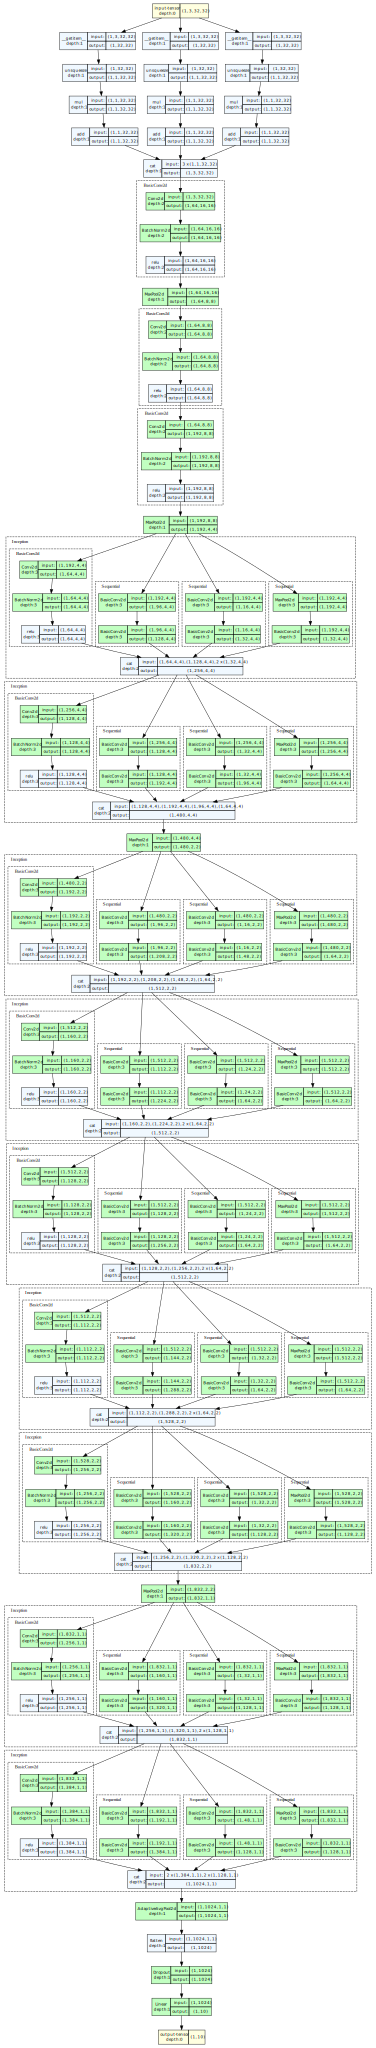

In [12]:
visualize(neural_network, "GoogLeNet with transform last layer")

In [13]:
_, gnet_first_acc = train_and_test(train_dataset_googlenet, test_dataset_googlenet, neural_network)

TRAIN:
Epoch[1]: Loss = 1.3379, Train accuracy = 0.6257, Time epoch = 62.2952
Epoch[2]: Loss = 0.8605, Train accuracy = 0.7293, Time epoch = 65.8723
Epoch[3]: Loss = 0.7732, Train accuracy = 0.7487, Time epoch = 66.1303
Epoch[4]: Loss = 0.7313, Train accuracy = 0.7565, Time epoch = 66.2433
Epoch[5]: Loss = 0.7081, Train accuracy = 0.7613, Time epoch = 65.9070
Total time 326.45599389076233
TEST:
Loss = 0.0015, Test accuracy = 0.7509


In [14]:
neural_network = create_model_second(models.googlenet, models.GoogLeNet_Weights.DEFAULT)

Model: GoogLeNet with transform two last layers
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d

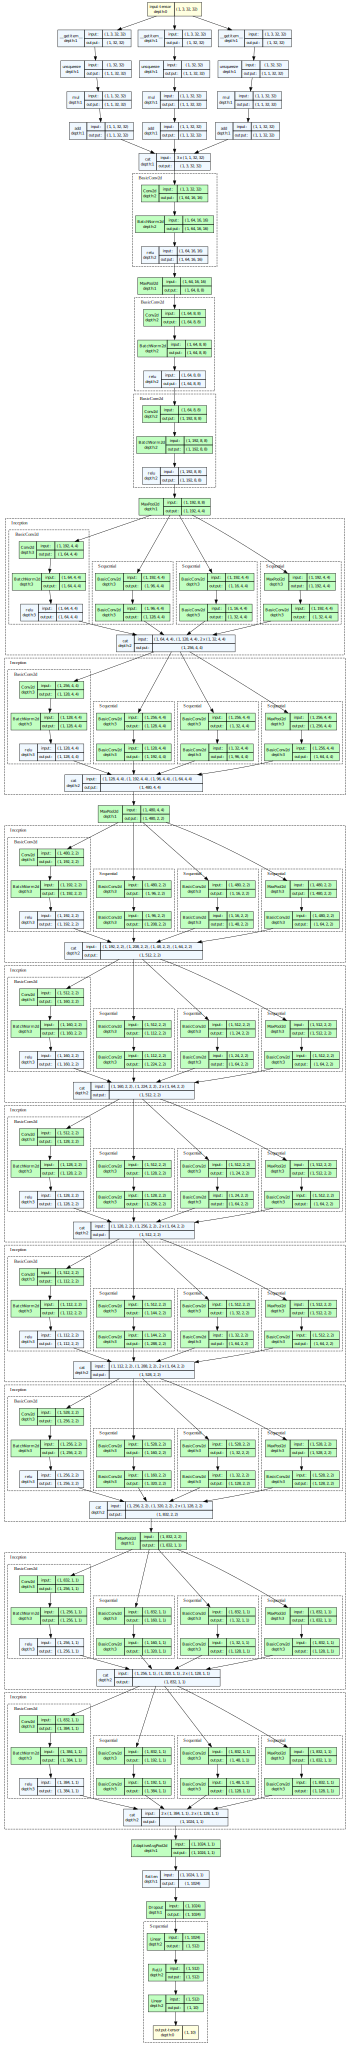

In [15]:
visualize(neural_network, "GoogLeNet with transform two last layers")

In [16]:
_, gnet_second_acc = train_and_test(train_dataset_googlenet, test_dataset_googlenet, neural_network)

TRAIN:
Epoch[1]: Loss = 0.9530, Train accuracy = 0.6895, Time epoch = 65.0574
Epoch[2]: Loss = 0.7106, Train accuracy = 0.7546, Time epoch = 64.4580
Epoch[3]: Loss = 0.6907, Train accuracy = 0.7608, Time epoch = 64.6560
Epoch[4]: Loss = 0.6807, Train accuracy = 0.7642, Time epoch = 64.7978
Epoch[5]: Loss = 0.6626, Train accuracy = 0.7698, Time epoch = 64.9474
Total time 323.9204914569855
TEST:
Loss = 0.0014, Test accuracy = 0.7606


##ResNet

In [17]:
train_dataset_resnet, test_dataset_resnet = download_datasets(models.ResNet152_Weights.IMAGENET1K_V2.DEFAULT.transforms())

Files already downloaded and verified
Files already downloaded and verified


In [18]:
neural_network = create_model_first(models.resnet152, models.ResNet152_Weights.IMAGENET1K_V2.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 180MB/s]  


In [19]:
visualize(neural_network, "ResNet152 with transform last layer")

Model: ResNet152 with transform last layer
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv

In [20]:
_, resnet_first_acc = train_and_test(train_dataset_resnet, test_dataset_resnet, neural_network)

TRAIN:
Epoch[1]: Loss = 1.0856, Train accuracy = 0.7014, Time epoch = 176.0986
Epoch[2]: Loss = 0.6319, Train accuracy = 0.8051, Time epoch = 176.5380
Epoch[3]: Loss = 0.5480, Train accuracy = 0.8270, Time epoch = 176.3805
Epoch[4]: Loss = 0.5033, Train accuracy = 0.8382, Time epoch = 176.7946
Epoch[5]: Loss = 0.4741, Train accuracy = 0.8469, Time epoch = 175.8469
Total time 881.6625485420227
TEST:
Loss = 0.0010, Test accuracy = 0.8349


In [21]:
neural_network = create_model_second(models.resnet152, models.ResNet152_Weights.IMAGENET1K_V2.DEFAULT)

In [22]:
visualize(neural_network, "ResNet152 with transform two last layer")

Model: ResNet152 with transform two last layer
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): 

In [23]:
_, resnet_second_acc = train_and_test(train_dataset_resnet, test_dataset_resnet, neural_network)

TRAIN:
Epoch[1]: Loss = 0.6818, Train accuracy = 0.7810, Time epoch = 176.5101
Epoch[2]: Loss = 0.4570, Train accuracy = 0.8456, Time epoch = 176.1927
Epoch[3]: Loss = 0.4103, Train accuracy = 0.8597, Time epoch = 176.5362
Epoch[4]: Loss = 0.3710, Train accuracy = 0.8723, Time epoch = 176.4328
Epoch[5]: Loss = 0.3359, Train accuracy = 0.8857, Time epoch = 176.6045
Total time 882.2804148197174
TEST:
Loss = 0.0010, Test accuracy = 0.8411


## VitB16

In [24]:
train_dataset_vit, test_dataset_vit = download_datasets(models.ViT_B_16_Weights.DEFAULT.transforms())

Files already downloaded and verified
Files already downloaded and verified


In [25]:
def create_vit_first(class_model, weights):
  neural_network = class_model(weights = weights)

  for params in neural_network.parameters():
    params.requires_grad = False

  input_layers = neural_network.heads[0].in_features

  neural_network.heads = torch.nn.Linear(input_layers, 10)
  return neural_network

def create_vit_second(class_model, weights):
  neural_network = class_model(weights = weights)

  for params in neural_network.parameters():
    params.requires_grad = False

  input_layers = neural_network.heads[0].in_features

  neural_network.heads = torch.nn.Sequential(
        torch.nn.Linear(input_layers, input_layers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(input_layers//2, 10),
        )
  return neural_network

In [26]:
neural_network = create_vit_first(models.vit_b_16, models.ViT_B_16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 76.3MB/s] 


Model: VIT_B_16 with transform last layer
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06

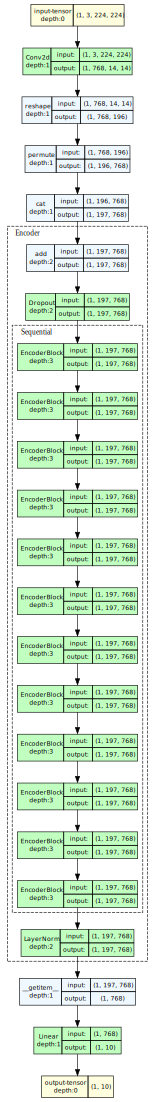

In [27]:
visualize(neural_network, "VIT_B_16 with transform last layer", (1, 3, 224, 224))

In [28]:
def train_and_test_vit(train_dataset, test_dataset, neural_network):
  train_data_loader, test_data_loader = get_loaders(train_dataset, test_dataset)

  neural_network.to(device)

  optimizer = torch.optim.Adam(
    neural_network.heads.parameters(),
    lr = learning_rate)

  print("TRAIN SECTION")
  train(neural_network, train_data_loader, num_epochs, loss_function, optimizer, device)

  print("TEST SECTION")
  return test(neural_network, test_data_loader, device)

In [29]:
_, vit_first_acc = train_and_test_vit(train_dataset_vit, test_dataset_vit, neural_network)

TRAIN SECTION
Epoch[1]: Loss = 0.4875, Train accuracy = 0.8844, Time epoch = 297.4250
Epoch[2]: Loss = 0.2042, Train accuracy = 0.9378, Time epoch = 297.3458
Epoch[3]: Loss = 0.1750, Train accuracy = 0.9452, Time epoch = 296.7632
Epoch[4]: Loss = 0.1593, Train accuracy = 0.9497, Time epoch = 296.9030
Epoch[5]: Loss = 0.1484, Train accuracy = 0.9531, Time epoch = 297.0558
Total time 1485.4972763061523
TEST SECTION
Loss = 0.0003, Test accuracy = 0.9469


In [30]:
neural_network = create_vit_second(models.vit_b_16, models.ViT_B_16_Weights.DEFAULT)

Model: VIT_B_16 with transform two last layer
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1

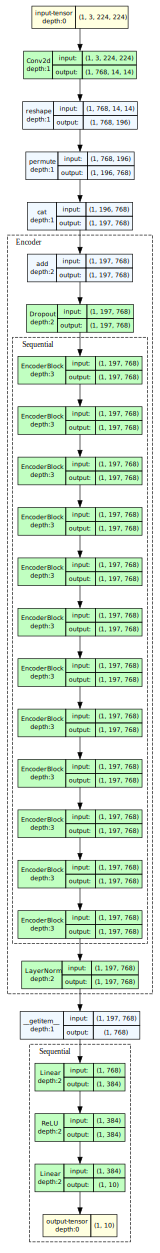

In [31]:
visualize(neural_network, "VIT_B_16 with transform two last layer", (1, 3, 224, 224))

In [32]:
_, vit_second_acc = train_and_test_vit(train_dataset_vit, test_dataset_vit, neural_network)

TRAIN SECTION
Epoch[1]: Loss = 0.2949, Train accuracy = 0.9191, Time epoch = 296.6478
Epoch[2]: Loss = 0.1402, Train accuracy = 0.9531, Time epoch = 296.8945
Epoch[3]: Loss = 0.1200, Train accuracy = 0.9600, Time epoch = 297.1609
Epoch[4]: Loss = 0.1050, Train accuracy = 0.9646, Time epoch = 297.3019
Epoch[5]: Loss = 0.0890, Train accuracy = 0.9697, Time epoch = 297.0865
Total time 1485.095776796341
TEST SECTION
Loss = 0.0003, Test accuracy = 0.9499


## ShuffleNet

In [33]:
train_dataset_shuffle, test_dataset_shuffle = download_datasets(models.ShuffleNet_V2_X2_0_Weights.DEFAULT.transforms())

Files already downloaded and verified
Files already downloaded and verified


In [34]:
neural_network = create_model_first(models.shufflenet_v2_x2_0, models.ShuffleNet_V2_X2_0_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████| 28.4M/28.4M [00:00<00:00, 122MB/s] 


Model: ShuffleNet with transform last layer
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=

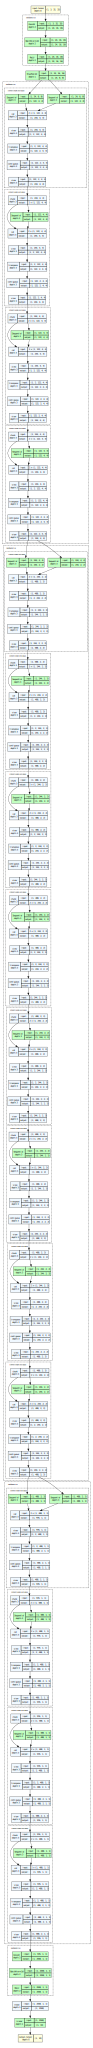

In [35]:
visualize(neural_network, "ShuffleNet with transform last layer")

In [36]:
_, shuffle_first_acc = train_and_test(train_dataset_shuffle, test_dataset_shuffle, neural_network)

TRAIN:
Epoch[1]: Loss = 1.0784, Train accuracy = 0.7026, Time epoch = 58.5580
Epoch[2]: Loss = 0.6285, Train accuracy = 0.8081, Time epoch = 58.7709
Epoch[3]: Loss = 0.5407, Train accuracy = 0.8276, Time epoch = 58.7645
Epoch[4]: Loss = 0.4933, Train accuracy = 0.8413, Time epoch = 57.9604
Epoch[5]: Loss = 0.4611, Train accuracy = 0.8516, Time epoch = 58.3953
Total time 292.45334219932556
TEST:
Loss = 0.0010, Test accuracy = 0.8429


In [37]:
neural_network = create_model_second(models.shufflenet_v2_x2_0, models.ShuffleNet_V2_X2_0_Weights.DEFAULT)

Model: ShuffleNet with transform two last layer
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, 

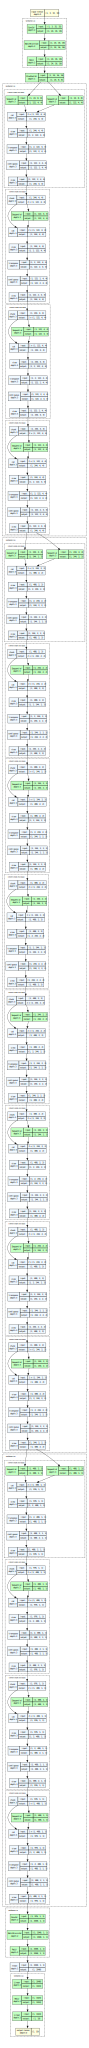

In [38]:
visualize(neural_network, "ShuffleNet with transform two last layer")

In [39]:
_, shuffle_second_acc = train_and_test(train_dataset_shuffle, test_dataset_shuffle, neural_network)

TRAIN:
Epoch[1]: Loss = 0.6566, Train accuracy = 0.7806, Time epoch = 58.2752
Epoch[2]: Loss = 0.4287, Train accuracy = 0.8533, Time epoch = 58.3639
Epoch[3]: Loss = 0.3820, Train accuracy = 0.8674, Time epoch = 58.8056
Epoch[4]: Loss = 0.3380, Train accuracy = 0.8811, Time epoch = 58.1293
Epoch[5]: Loss = 0.3041, Train accuracy = 0.8941, Time epoch = 58.2612
Total time 291.8393204212189
TEST:
Loss = 0.0009, Test accuracy = 0.8479


## 5. Гистограмма

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

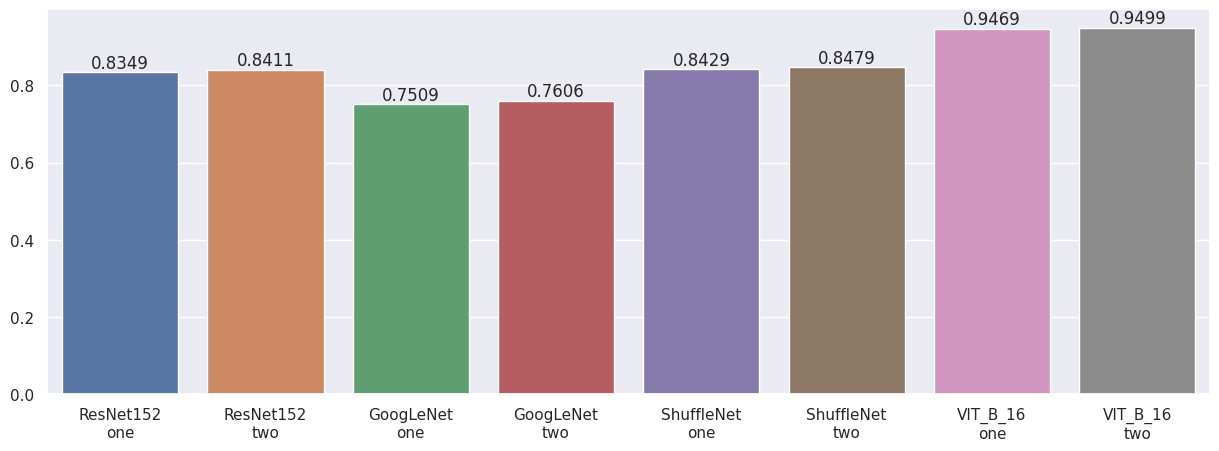

In [47]:
import seaborn

for_gist = {
    "ResNet152\none": resnet_first_acc.item(),
    "ResNet152\ntwo": resnet_second_acc.item(),
    "GoogLeNet\none": gnet_first_acc.item(),
    "GoogLeNet\ntwo": gnet_second_acc.item(),
    "ShuffleNet\none": shuffle_first_acc.item(),
    "ShuffleNet\ntwo": shuffle_second_acc.item(),
    "VIT_B_16\none": vit_first_acc.item(),
    "VIT_B_16\ntwo": vit_second_acc.item()
}

seaborn.set(rc={'figure.figsize': (15, 5)})

ax = seaborn.barplot(x=list(for_gist.keys()), y=list(for_gist.values()))

for i in ax.containers:
    ax.bar_label(i,)